# Линейная регрессия

Здесь хороший повод поговорить о математике, но меня просили не. Что ж, надеюсь, это не помешает вам сопоставить теорию с практикой. 

Суть: у нас есть несколько параметров и есть некоторое числовое значение, зависимость которого от этих самых параметров мы и хотим узнать. Например: есть количество квартир в доме, есть площадь парковки возле дома и есть площадь конкретной квартиры. По этим трём параметрам нужно найти стоимость этой квартиры. Пара из трёх параметров и цены квартиры составляют одну запись/один индивид. Таких индивидов у нас несколько (желательно довольно много). 

## Цели линейной регрессии

Собственно линейную регрессию используют для двух целей:
* Предсказать значение нового индивида при известных параметрах
* Объяснить как влияет каждый из параметров на искомое значение

## Когда её используют

Обычно её используют для получения первых выводов из данных, перед тем как начать использовать ~~нормальные~~ более сложные модели. 

## Какой у нас план?

В виду ограничений, будем пытаться разобраться по ходу, надеюсь, вам будет понятно. Вообще будет здорово, если освежите теоретические основы, но постараюсь всё показать на живом примере.

## Библиотека 

По традиции, нам нужно для начала установить библиотеку. В нашем случае на выбор предоставляется две библиотеки: `statsmodels` и `scikit-learn` (читают *склёрн*). Первая хороша для тех, кто дружит с матстатом, поэтому это не наш случай и выбираем вторую. Функционал этих библиотек неограничен исключительно линейной регрессией, но пока мы рассмотрим только её. 

In [ ]:
# !pip install scikit-learn

### Импорт

Внезапно, импортируем мы её не как `import scikit-learn` и даже не `import sklearn`. Библиотека довольно объёмна, а нам нужны только отдельные её модули, даже отдельные части её модулей. Для большей целостности импортируем всё необходимое здесь, а по ходу дела буду объяснять, что именно мы здесь набрали.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Начало работы / обработка датасета

### Обзор

Самое первое, что необходимо сделать $\text{---}$ так это узнать какие данные у нас есть и что мы хотим вообще найти. 

> Online property companies offer valuations of houses using machine learning techniques. The aim of this report is to predict the house sales in King County, Washington State, USA using Multiple Linear Regression (MLR). The dataset consisted of historic data of houses sold between May 2014 to May 2015.

В общем, по данным о недвижке будем предсказывать стоимость.

In [2]:
file_name = 'kc_house_data.csv'

df = pd.read_csv(file_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

### Удаление "лишних" признаков

Сразу удалим то, что нам не нужно. 
* `id` $\text{---}$ идентификационный код никак не может повлиять на стоимость квартиры.
* `zipcode` $\text{---}$ это америакнский почтовый индекс, его можно использовать в анализе, но *feature exploration* такого уровня выходит за рамки нашего курса.
* `lat` и `long` $\text{---}$ широта и долгота, та же ситуация, что и выше. 

In [3]:
df.drop(['id', 'zipcode', 'lat', 'long'], axis=1, inplace=True)
df['price'] = df.pop('price') # для красоты поставим в конец
df.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,1340,5650,221900.0
1,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,1690,7639,538000.0
2,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,2720,8062,180000.0
3,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,1360,5000,604000.0
4,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,1800,7503,510000.0


### Модификация

Теперь разберёмся с оставшимися:
* `bedrooms` и `bathrooms` $\text{---}$ соответственно количество спален и ванных комнат. Внезапно количество ванных комнат не обязательно натуральное число, но что с них взять $\text{---}$ у них шоколадные батончики в дюймах и рутбир в пинтах. 
* `sqft_living` и `sqft_lot` $\text{---}$ соответственно площадь жилых помещений и земельных участков. 
* `sqft_living15` и `sqft_lot15` $\text{---}$ соответственно площадь жилых помещений и земельных участков, но в этот раз не конкретной недвижки, а ближайших 15 объектов. 
* `sqft_basement` и `sqft_above` $\text{---}$ соответственно площадь подвальных помещений и надземных. 
* `floors` $\text{---}$ количество этажей, та же история, что и с ванными комнатами.
* `waterfront` $\text{---}$ находится возле набережной.
* `viewfront`, `condition` и `grade` $\text{---}$ те или иные качественные оценки дома и окружающего вида. 
* `date` $\text{---}$ дата продажи дома.

Данные у нас с мая 14-ого по май 15-ого, допустим, что различия между месяцами больше, чем различия внутри месяца, поэтому преобразуем дату в строку вида `MM.YY`, сделаем из этого категориальную переменную. Вообще правильно было бы сделать несколько предположений, попробовать объединить по сезонам, кварталам, полугодиям, но в силу задач нашего курса оставим эту важную работу вам. Можете потом сообщить результаты.  

In [4]:
df['date'] = [f'"{d[4:6]}.{d[2:4]}"' for d in df["date"]]
df.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,"""10.14""",3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,1340,5650,221900.0
1,"""12.14""",3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,1690,7639,538000.0
2,"""02.15""",2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,2720,8062,180000.0
3,"""12.14""",4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,1360,5000,604000.0
4,"""02.15""",3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,1800,7503,510000.0


### Сохранение

Сохраним преобразованные данные, чтобы не проводить вышеописанное каждый раз. В нашем случае не критично, но привычка полезная.

In [ ]:
save_file_name = 'kc_house_data_mod.csv'
df.to_csv(save_file_name, index=False)
df = pd.read_csv(save_file_name)
df['date'] = df['date'].astype('category') # делаем категориальной

### Треин/тест

Далее разделим датасет на обучающий и проверочный набор данных. В проверочный набор данных мы не лезем. Совсем не лезем. Даже не смотрим. Это нечестно. Так делать не надо. 

In [4]:
seed = 1 # зерно для воспроизводимости результатов от случайных ф-ций
train, test = train_test_split(df, train_size=0.8, random_state=seed)

### Анализ фич

Не помню, но на всякий случай: фича = признак = независимая переменная.

Вообще, с точки зрения математики, необходимо обратить внимание на следующие признаки: `sqft_living`, `sqft_basement` и `sqft_above`. Дело в том, что они отчасти перекрывают друг друга. Если подвальные помещения оборудованы под жилые, то площадь подвального помещения уже будет учтена в площади жилых помещений. Если подвала нет, то площадь надземных помещений (как мы увидим далее) часто равна площади жилых помещений, тем самым она будет учтена дважды. В некотором смысле мы получаем такое страшное словосочетание как "линейная комбинация", а применяя метод линейной регрессии желательно не иметь в своих данных линейных комбинаций, т.к. есть методы, которые вообще не сойдутся при таких условиях. Мы попытаемся как-то разрешить эту проблему, но предупреждаю сразу, что я не буду пытаться достичь лучшего результата, поскольку, ну, это просто учебный пример. Посмотрим что мы можем вытащить.

In [7]:
# Количество объектов, где сумма площади надземных и подземных помещений не
# равна площади надземных помещений   
train[(train['sqft_above'] + train['sqft_basement']) 
      != train['sqft_living']].shape[0]

2

In [8]:
# Количество объектов, где площадь надземных помещений не равна площади жилых 
# помещений, при отсутствующем подвале (очевидно, что это один из тех двух
# случаев).
len(train[(train['sqft_above'] != train['sqft_living']) 
          & (train['sqft_basement'] == 0)])

1

#### Ой...

И если вы не сказали сейчас: "Так, минуточку", то это было зря. Можете сказать это сейчас, а я объясню почему. Вернёмся к выводу информации о датасете. Я дублировать не буду, сами посмотрите. Если присмотреться внимательно к выводу информации о датафрейме то можно заметить, что у нас есть целых два пропущенных значения в площади надземных помещений. Проверим это. 

In [9]:
train.isna().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

По *счастливому совпадению* (не забывайте, что у нас учебный проект) все пропущенные значения оказались в нашей обучающей выборке. Если бы пропущенные значения оказались бы в тестовом наборе данных, то нужно было бы придумать метод заполнения данных исходя только из обучающего набора данных и применять из вслепую на тестовом наборе данных.

Самые примитивные методы устранения пропущенных значений мы рассматривали в главе про Pandas, но сейчас нам не нужны ни примитивные, ни сложные методы. Мы поступим довольно логично и устраним пропуски следующим способом. Обратим внимание, что сумма площадей надземных и подземных помещений не равна площади жилых помещений только в двух случаях, а именно когда площадь надземных помещений неизвестна (поскольку неизвестное + известное = неизвестное). Сейчас мы это продемонстрируем для тех, кто не верит.

In [10]:
missing_rows = train[train['sqft_above'].isna()]
print(missing_rows, '\n')

print(missing_rows['sqft_above'] + missing_rows['sqft_basement'])

       date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
17  "05.14"         4        1.0         1600      4300     1.5           0   
10  "04.15"         3        2.5         3560      9796     1.0           0   

    view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
17     0          4      7         NaN              0      1916             0   
10     0          3      8         NaN           1700      1965             0   

    sqft_living15  sqft_lot15     price  
17           1610        4300  485000.0  
10           2210        8925  662500.0   

17   NaN
10   NaN
dtype: float64


Так вот, исходя из вышесказанного, приравняем площади надземных помещений разницу между площадями жилых и подземных помещений. Кстати, текст никто не вычитывает, а я довольно часто могу оставить неверное склонение слов из-за того, что в голове уже 10 раз изменил формулировку предложения, так что приношу свои извинения, если ваши глаза к этому моменту уже вытекли. Ну или как говорится: "А сердечник для двигателя я сделаю из дерева, потому что до этого момента, ясень пень, никто не дочитает". А мы двигаемся дальше.

#### Модификация

In [5]:
mask = train['sqft_above'].isna()
train.loc[mask, 'sqft_above'] = train.loc[mask, 'sqft_living'] \
                                - train.loc[mask, 'sqft_basement']
train.isna().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

Ну красота же? Вообще говоря не обязательно было выделять маску (если забыл $\text{---}$ беги перечитывать про булеву индексацию), поскольку векторизация, оптимизация, C, ну вы поняли короче, всё равно нормально работало бы, тем более, что у нас не гигатоны данных. А второе, что мы должны были бы проделать то же самое и с тестовым датасетом, но поскольку по *счастливой случайности* все пропущенные значения оказались в трейне (обучающей части), то это крайне важное дело я предоставлю вам. Как сделаете, так возвращайтесь.

In [12]:
# здесь мог быть быть ваш код

#### Удаление

А теперь мы вернулись к тому, с чего начали, что у нас, теперь уже всегда, площадь живых помещений равна сумме площадей надземных и подземных, то есть всё же выходит линейная комбинация признаков, а нам такое не надо. Удалим признак площади жилых помещений. Он нам, правда, понадобится в нестоль отдалённом будущем, но это уже совершенно другая история. 

In [6]:
train.drop('sqft_living', axis=1, inplace=True)
# не забываем повторить на тесте
test.drop('sqft_living', axis=1, inplace=True) 

## Визуализация

Что ж, нам есть ещё где работать с датасетом (и работы довольно много), но пока остановимся на достигнутом. Посмотрим, что мы имеем сейчас.

### Описательная статистика

In [7]:
train.head()

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
7291,"""10.14""",3,1.75,7021,1.0,0,2,4,7,1390.0,800,1953,0,2180,7155,353000.0
14835,"""01.15""",3,2.50,6840,2.0,0,0,3,9,2370.0,0,1987,0,1590,4400,300523.0
15880,"""06.14""",2,1.00,3800,1.0,0,0,3,7,1230.0,0,1928,0,1610,3800,435000.0
8812,"""11.14""",4,2.25,9963,1.0,0,0,4,9,2200.0,310,1967,0,3110,9963,800000.0
17220,"""08.14""",3,1.00,7491,1.0,0,0,4,6,1160.0,0,1917,0,1800,2267,417500.0


Мы объясним позже, почему мы не включили в описательную статистику некоторые признаки. Впрочем, может догадаться и сами.

In [8]:
excluded_features = {'yr_built', 'yr_renovated', 'waterfront', 'view', 
                     'condition', 'grade', 'floors', 'bedrooms',
                     'bathrooms', 'date'}
features = list(set(train.columns) - excluded_features)

train[features].describe()

,price,sqft_lot15,sqft_above,sqft_living15,sqft_lot,sqft_basement
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000
mean,5.378806e+05,12790.231984,1782.821920,1984.131463,1.521099e+04,291.764372
std,3.539798e+05,27728.922431,816.765091,681.613827,4.282989e+04,441.081555
min,7.500000e+04,659.000000,370.000000,399.000000,5.200000e+02,0.000000
25%,3.220000e+05,5100.000000,1190.000000,1490.000000,5.040000e+03,0.000000
50%,4.500000e+05,7615.000000,1560.000000,1840.000000,7.605000e+03,0.000000
75%,6.450000e+05,10067.500000,2210.000000,2360.000000,1.063075e+04,560.000000
max,5.570000e+06,871200.000000,8020.000000,5790.000000,1.651359e+06,4820.000000


### Качественные переменные

Сейчас будет очень много графиков, смотрите на них внимательно, объяснение будет после котика (он для привлечения внимания).

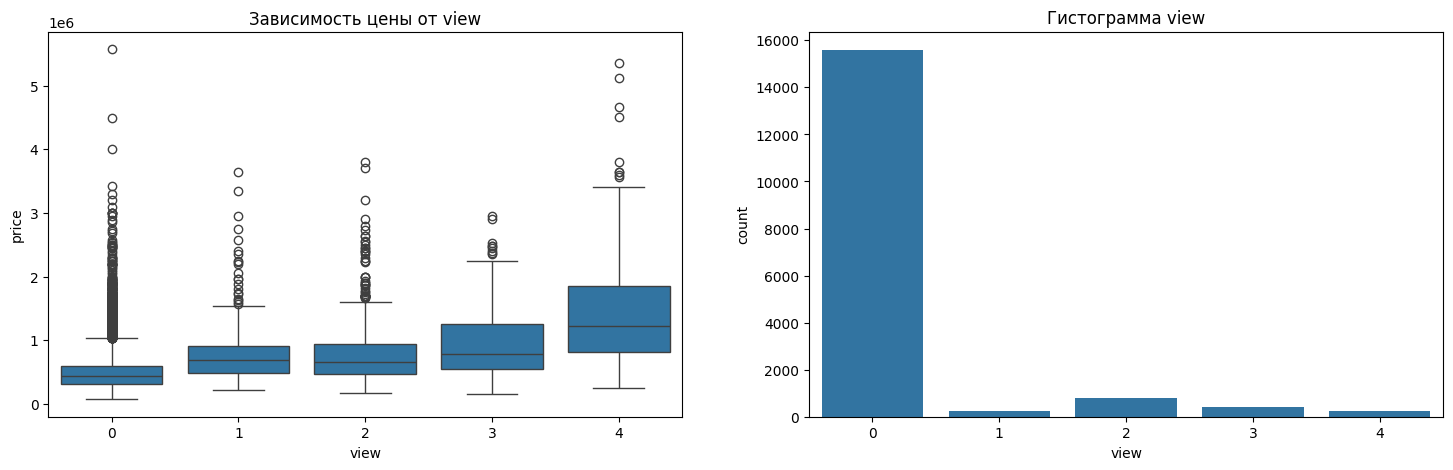

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='view', y='price', data=train, ax=axes[0])
sns.countplot(x='view', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от view')
axes[1].set_title('Гистограмма view')
axes[0].set_xlabel('view')
axes[1].set_xlabel('view')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

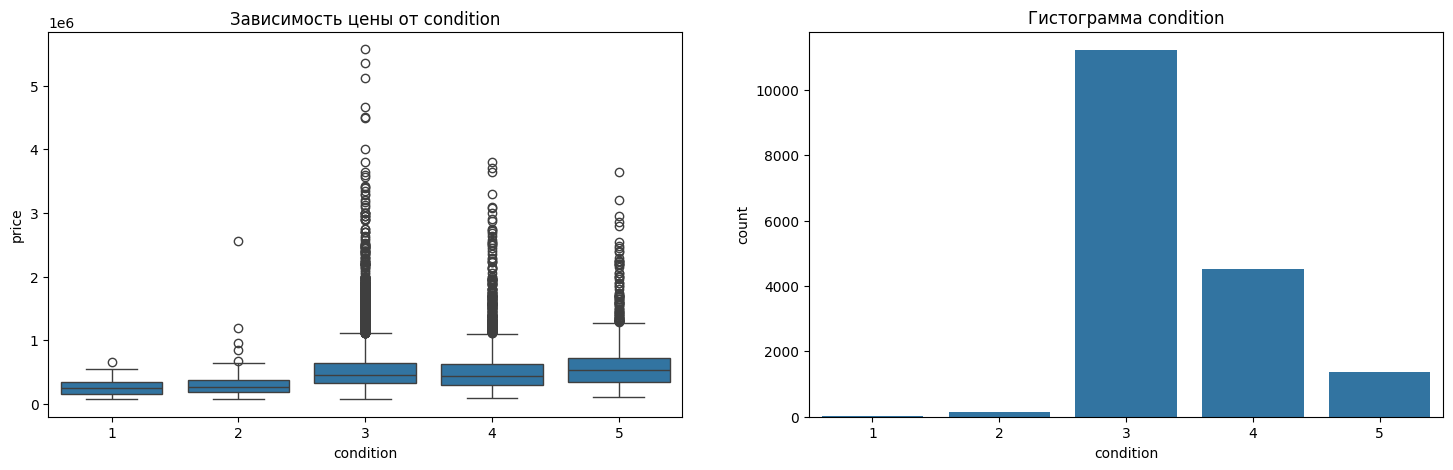

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='condition', y='price', data=train, ax=axes[0])
sns.countplot(x='condition', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от condition')
axes[1].set_title('Гистограмма condition')
axes[0].set_xlabel('condition')
axes[1].set_xlabel('condition')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

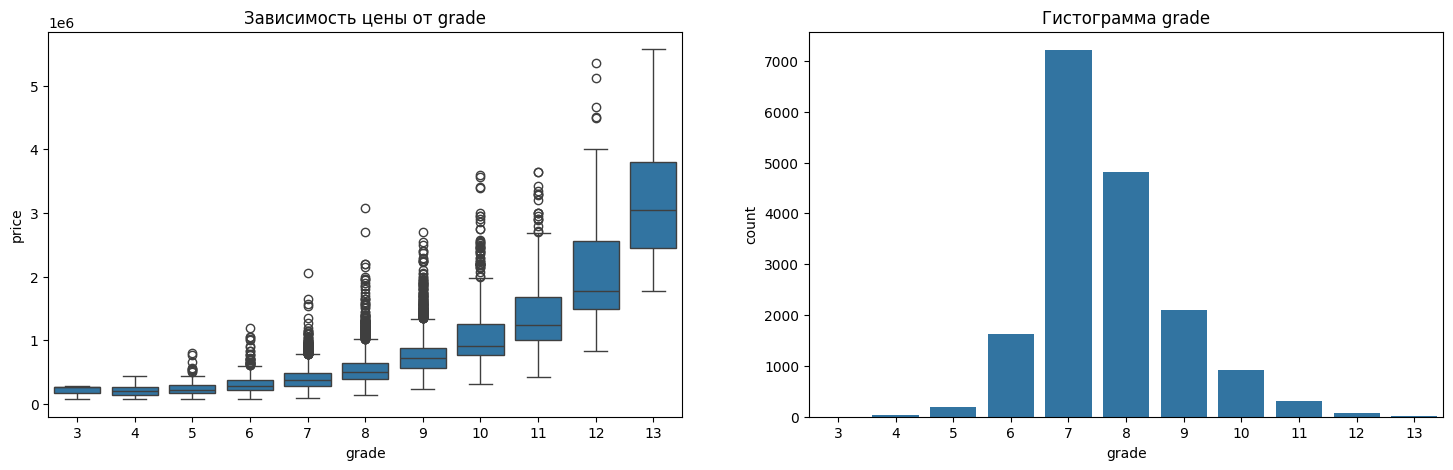

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='grade', y='price', data=train, ax=axes[0])
sns.countplot(x='grade', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от grade')
axes[1].set_title('Гистограмма grade')
axes[0].set_xlabel('grade')
axes[1].set_xlabel('grade')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

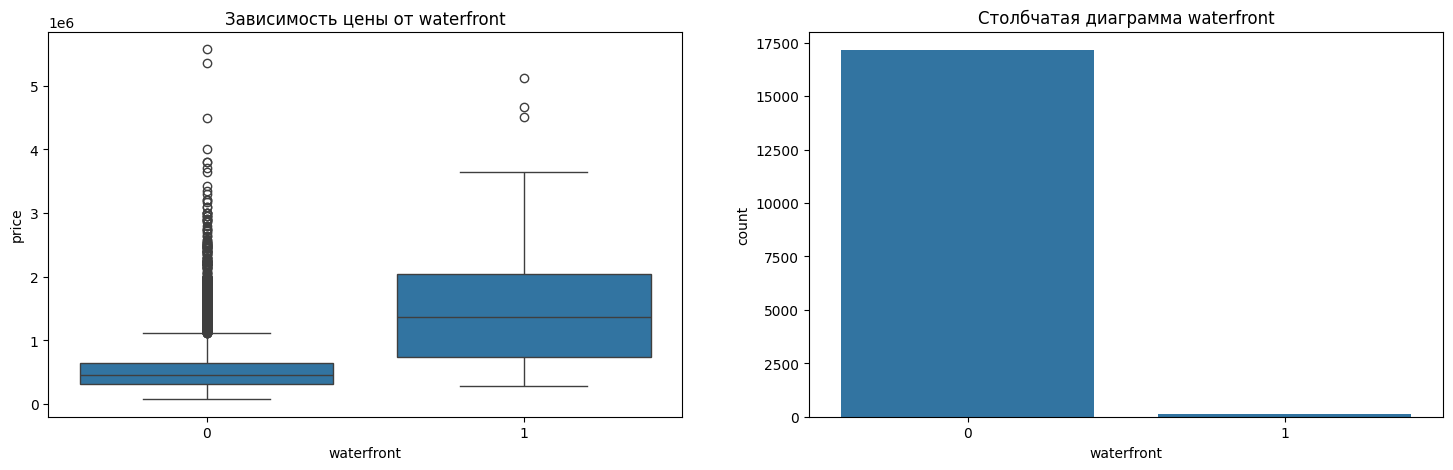

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='waterfront', y='price', data=train, ax=axes[0])
sns.countplot(x='waterfront', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от waterfront')
axes[1].set_title('Столбчатая диаграмма waterfront')
axes[0].set_xlabel('waterfront')
axes[1].set_xlabel('waterfront')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

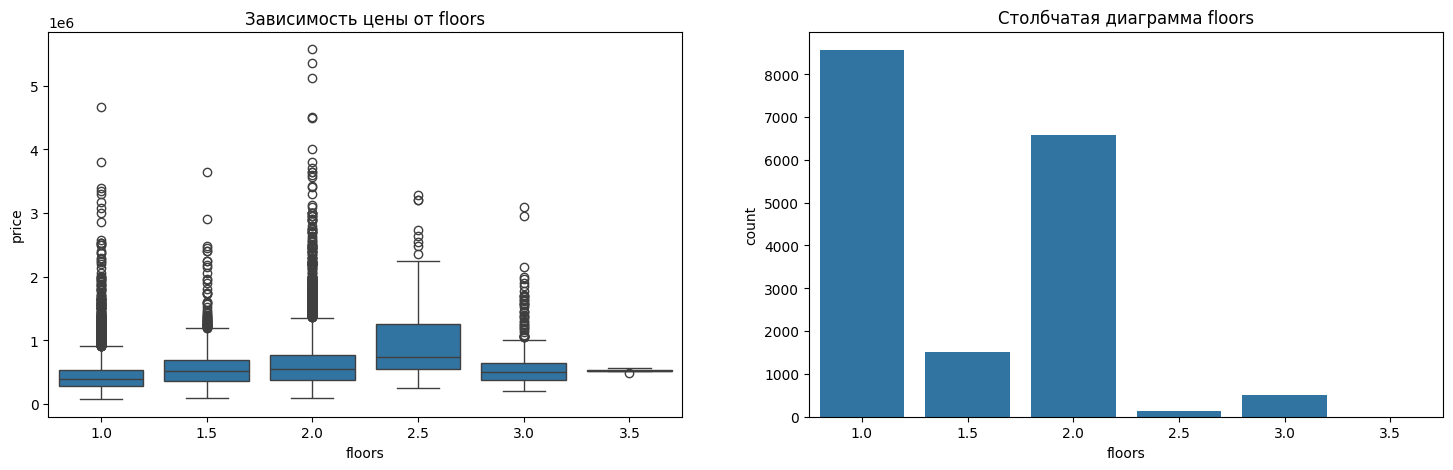

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='floors', y='price', data=train, ax=axes[0])
sns.countplot(x='floors', data=train, ax=axes[1])
axes[0].set_title('Зависимость цены от floors')
axes[1].set_title('Столбчатая диаграмма floors')
axes[0].set_xlabel('floors')
axes[1].set_xlabel('floors')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

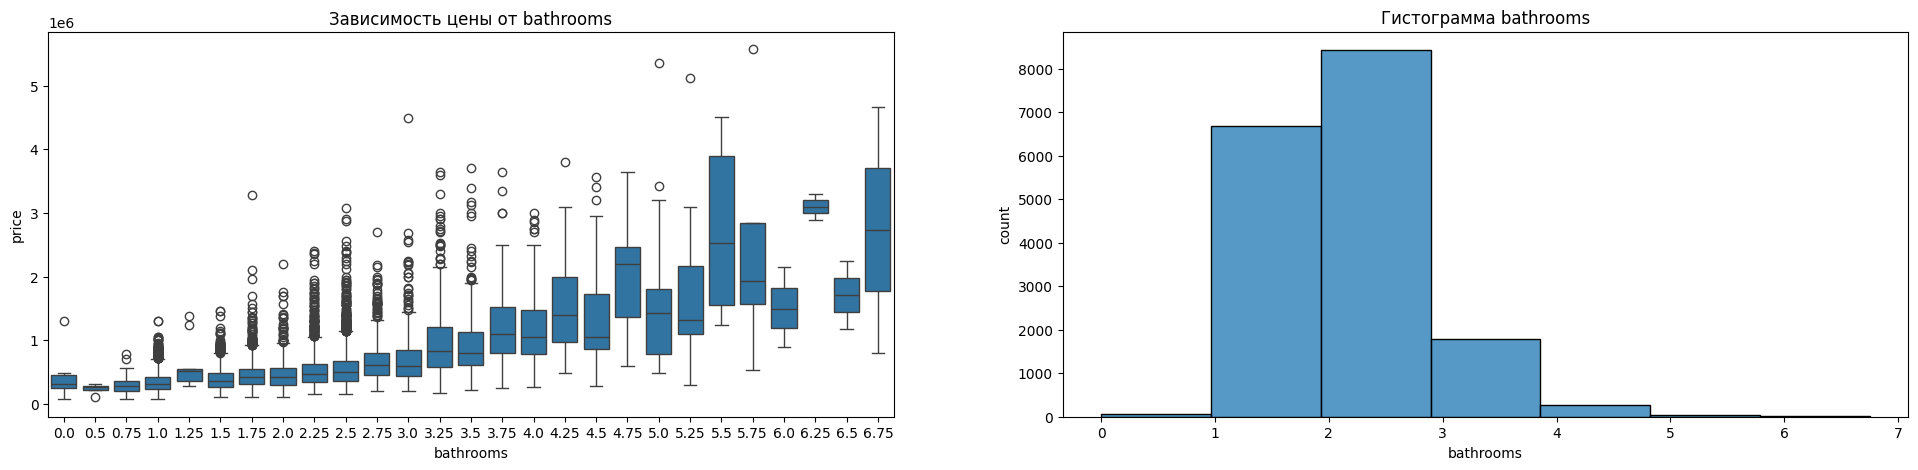

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(x='bathrooms', y='price', data=train, ax=axes[0])
sns.histplot(x='bathrooms', data=train, ax=axes[1], bins=7)
axes[0].set_title('Зависимость цены от bathrooms')
axes[1].set_title('Гистограмма bathrooms')
axes[0].set_xlabel('bathrooms')
axes[1].set_xlabel('bathrooms')
axes[0].set_ylabel('price')
axes[1].set_ylabel('count')
plt.show()

![image](warning.png)

Теперь проанализируем что вышло:
* Чем лучше вид (`view`), тем больше и цена, и разброс. 
* Если состояние (`condition`) 1 или 2, то цена будем меньше, чем в остальных случаях (как видели, с улучшением состояния выше тройки цена меняется не сильно).
* С ростом `grade` (оценки?) и цена, и разброс растёт значительно.
* Дома возле набережной стоят больше.

### Корреляции

Кстати, графики (и не только) можно спрятать, если ткнуть на синую штуку слева (она будет синей, если ячейка в фокусе, иначе серой или её не будет вообще). Если что, то я знаю, что размер графиков можно настраивать, но мне удобнее, когда они большие, а когда они мне не нужны я их скрываю.

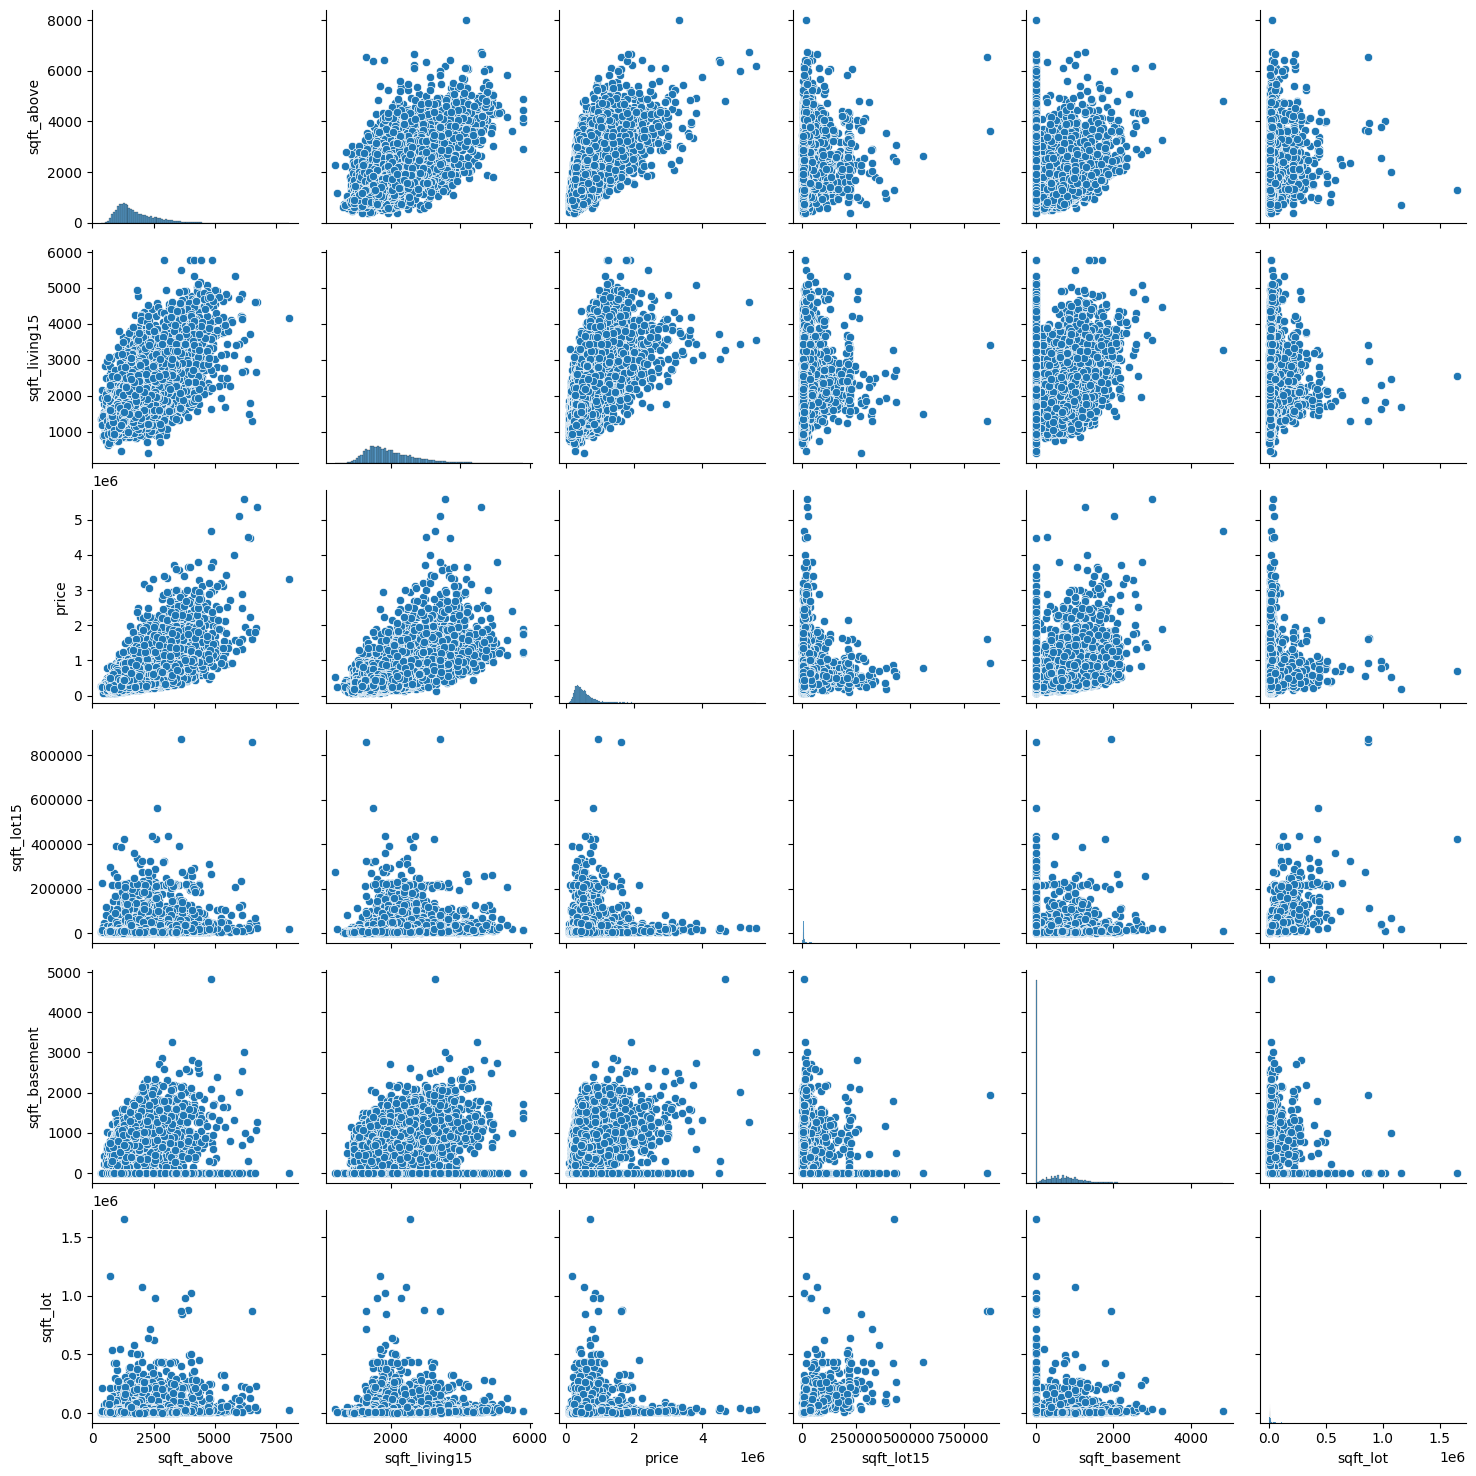

In [24]:
sns.pairplot(train[features])
plt.show()

Также построим корреляционную матрицу.

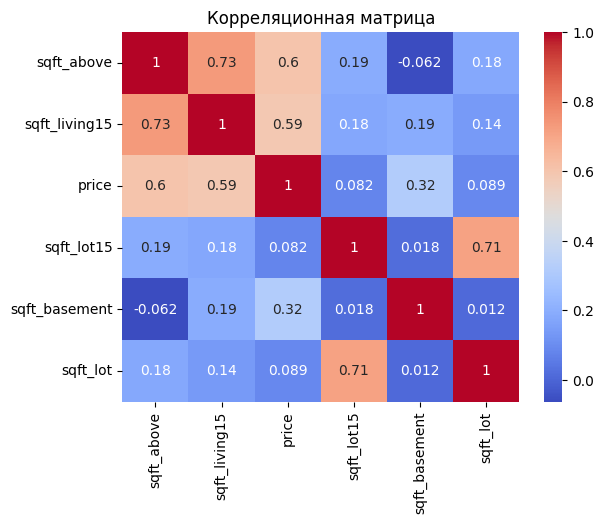

In [36]:
corr = train[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Из pairplot'а и корреляционной матрицы мы видим, что мы немного поторопились с удалением площади жилых помещений, но я уже об этом говорил. Не страшно, восстановить всегда сможем, а удалить обратно можем забыть. Так что временно восстанавливаем и смотрим новые корреляции.

In [40]:
sqft_living = train['sqft_above'] + train['sqft_basement']
# [0, 1] -- т.к. возвращает 2x2 матрицу, нам нужна не главная диагональ
liv_price = np.corrcoef(sqft_living, train['price'])[0, 1] 
liv_liv15 = np.corrcoef(sqft_living, train['sqft_living15'])[0, 1]

print(f'Корреляция между площадью жилых помещений и ценой: {liv_price}')
print('Корреляция между площадью жилых помещений и ей же у соседей: '
      f'{liv_liv15}')

Корреляция между площадью жилых помещений и ценой: 0.699114284032929
Корреляция между площадью жилых помещений и ей же у соседей: 0.756721428346318


Как видите корреляция оказалась больше, чем было на корреляционной матрице, но это норма, это нужно в первую очередь для того, как сильно будет влиять тот или иной признак на зависимую переменную.

### Гистограммы

Построим гистограммы заново, поскольку на pairplot'е их практически не видно.

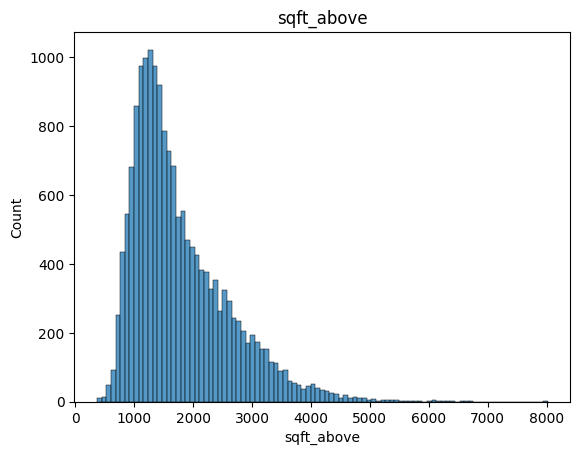

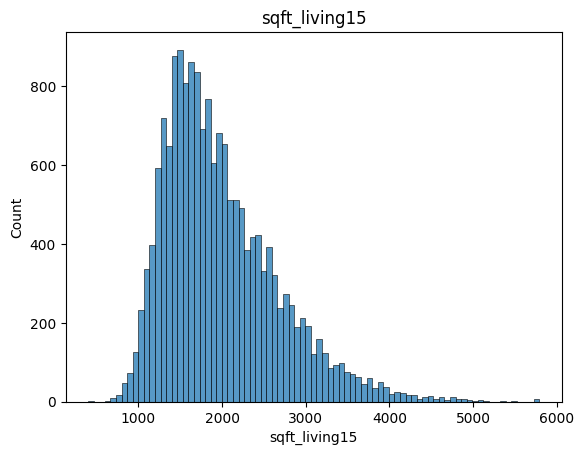

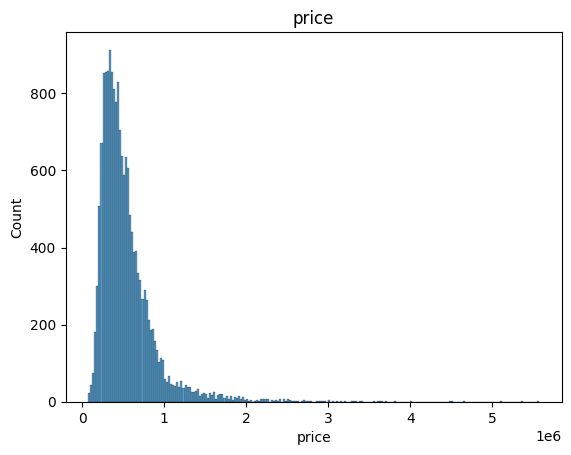

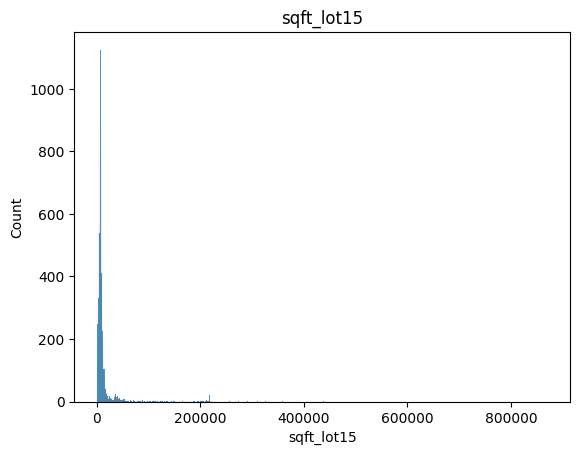

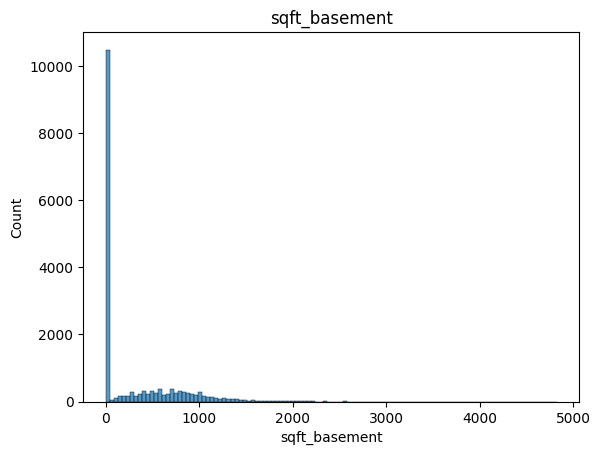

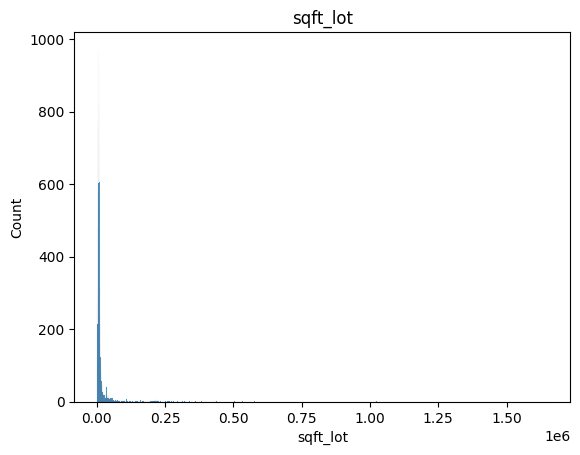

In [26]:
for f in features:
    plt.title(f)
    sns.histplot(train, x=f)
    plt.show()

Посмотрим на `sqft_basement`, где этот самый basement, собственно, есть (поскольку у большинства его нет и гистограмма становится нечитабельной). 

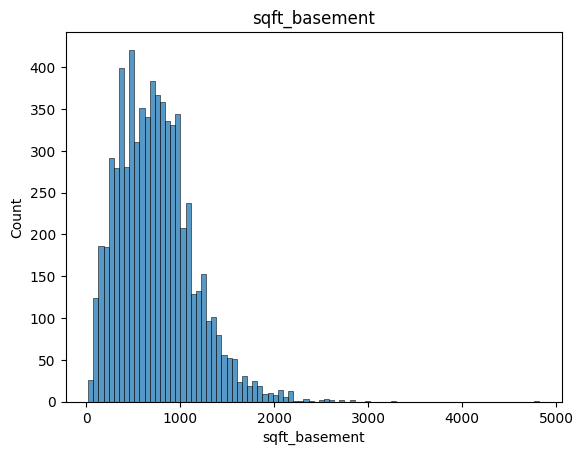

In [31]:
plt.title('sqft_basement')
sns.histplot(train[train['sqft_basement'] > 0], x='sqft_basement')
plt.show()

Как мы видим из гистограмм $\text{---}$ у нас очень длинный правый хвост. Ну, штука, которая понизу стелется справой стороны $\text{---}$ называется правым хвостом, слева $\text{---}$ левый. Это плохо, что он длинный. Если был бы длинный левый хвост, то это тоже плохо, они должны быть примерно одинаковы, ну, знаете, как в нормальном распределении. Это желательно. 

А ещё из функции `describe` мы увидели, что есть огромная разница между третим и четвёртым (т.е. максимумом) квартилем, какой нет между вторым и третьим. Это всё приводит нас к мысли, что в нашем датасете есть выбросы. Мысль хорошая и верная, но сейчас мы сделаем рекламную паузу. 

## Первая попытка

Добро пожаловать на открытый урок онлайн-школы Лоу-скиллз. Сегодня мы докажем вам, что машинное обучение $\text{---}$ это очень просто. После прохождения нашего курса вы сможете создать свой искусственный интеллект и заработать кучу денег. 

Рассмотрим самый просто метод МО $\text{---}$ линейную регрессию. У нас есть данные: их нужно разбить на обучающую и проверочную выборку.

In [48]:
t_train, t_test = train_test_split(train, test_size=0.2, 
                                   random_state=seed) # seed не забываем

В наших данных есть строковая переменная, она нам не нужна, удалим её.

In [49]:
t_train.drop('date', axis=1, inplace=True)
t_test.drop('date', axis=1, inplace=True)

Отделим фичи от цели (независимые переменные от зависимой).

In [50]:
y_t_train = t_train['price'] # выделяем зависимую переменную 
y_t_test = t_test['price']   # на трейн и тесте

X_t_train = t_train.drop('price', axis=1) # убираем её среди независимых
X_t_test = t_test.drop('price', axis=1)   # на трейн и тесте

Теперь создаём нашу модель линейной регрессии и обучаем её!

In [52]:
model = LinearRegression() # создали
model.fit(X_t_train, y_t_train) # обучили
pass

Предсказываем на тесте!

In [54]:
y_t_pred = model.predict(X_t_test)

Теперь посмотрим на результаты!

In [57]:
rmse = np.sqrt(mean_squared_error(y_t_test, y_t_pred))
r2 = r2_score(y_t_test, y_t_pred)
print("\nОценка модели:")
print("RMSE:", rmse)
print("R²:", r2)


Оценка модели:
RMSE: 211837.22706818226
R²: 0.6607420495959251


$R^2$ нашей модели больше $0.66$, а значит мы сделали очень хорошую модель. Приходите к нам и сможете сделать ещё лучше! 

In [61]:
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

## Рефлексия

Я завидую тем, кто поставил адблок. Так вот, как мы только что увидели "обучение модели" $\text{---}$ это самая **скучная** часть нашей работы. Бóльшая часть "нашей" работы это возня с данными и никакого праздника. 

То, что ~~мы~~ они в прошлой попытке выкинули дату на мороз, это, конечно, хорошо, но они это сделали только потому что иначе бы модель вообще не обучилась бы.